# Introduction to Pyro

![logo](pyro_plots.png)

Michael Zingale, Alice Harpole

Stony Brook University

## Why pyro?

  * Python is a good introductory language&mdash;it helps make the way these algorithms work clearer

  * High level introduction to core hydro algorithms for students
  
    * Supplemented with extensive notes deriving the methods ( https://github.com/Open-Astrophysics-Bookshelf/numerical_exercises)
    
  * Enables easy ability to rapidly prototype code&mdash;core intrastructure is in place
  
  * Allows for sharing exploration in Jupyter notebooks

## Design ideas:

  * _Clarity is emphasized over performance_

  * Single driver implements core evolution
    
  * Object-oriented structure: each solver provides a simulation class to manage the different parts of the update
  
  * All solvers are 2-d: right balance of complexity and usefulness
  
  * Realtime visualization when run in commandline mode

## History:

  - _First version in 2003_: python + Numeric + C extensions
  
  - _May 2004_: switch to python + numarray + C extensions
  
    - cvs commit:
  
      > convert from Numeric to numarray, since numarray seems to be the future.
        
  - _May 2012_: revived, rewritten in python + NumPy + f2py
  
  - _Nov 2018_: python + NumPy + Numba

## Our usage

  * We start new undergraduate researchers out with pyro to learn about simulation workflows
    * Typically have UG add a new problem setup

## Current Solvers

  * *linear advection*: 2nd and 4th order FV, WENO; CTU, RK, and SDC time integration
  
  * *compressible hydrodynamics*: 2nd order CTU PLM, 2nd order MOL RK, 4th order FV solver with RK or SDC integration
  
  * *shallow water hydrodynamics*
  
  * *multigrid*: force non-constant coefficient general elliptic equations
  
  * *implicit thermal diffusion*: using multigrid
  
  * *incompressible hydrodynamics*: 2nd order accurate approximate projection method
  
  * *low Mach number atmospheric hydrodynamics*: pseudo-imcompressible method
  
  * *special relativistic compressible hydrodynamics*

## Main driver:

* parse runtime parameters

* setup the grid

  * initialize the data for the desired problem

* do any necessary pre-evolution initialization

* evolve while t < tmax and n < max_steps

  * fill boundary conditions
  * get the timestep
  * evolve for a single timestep
  * t = t + dt
  * output
  * visualization

* clean-up

<div class="alert alert-block alert-info">
&nbsp;This driver is flexible enough for all of the time-dependent solvers
</div>

## Grids

* ``patch`` module manages grids and data that lives on them

* Fills boundaries, does prolongation/restriction for multigrid

* Many convenience functions

In [1]:
import mesh.patch as patch
import mesh.boundary as bnd
import numpy as np

In [2]:
g = patch.Grid2d(16, 16, ng=2)
print(g)

2-d grid: nx = 16, ny = 16, ng = 2


In [3]:
bc = bnd.BC(xlb="periodic", xrb="periodic", ylb="reflect", yrb="outflow")
print(bc)

BCs: -x: periodic  +x: periodic  -y: reflect-even  +y: outflow


In [4]:
d = patch.CellCenterData2d(g)
d.register_var("a", bc)
d.create()
print(d)

cc data: nx = 16, ny = 16, ng = 2
         nvars = 1
         variables:
               a: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: periodic     +x: periodic     -y: reflect-even +y: outflow     



## Grids

In [5]:
a = d.get_var("a")

Data is stored as an ``ArrayIndexer`` object, which makes it easy to implement differencing on the entire array.

To implement:
$$ b = \frac{a_{i+1,j} - a_{i-1,j}}{2 \Delta x}$$

In [6]:
b = g.scratch_array()
b.v()[:,:] = (a.ip(1) - a.ip(-1))/(2.0*a.g.dx)

## Running

* Each solver has a collection of problem setups (initial conditions) and inputs files

* Commandline:

  ```
  ./pyro.py solver problem inputs
  ```
  
* Jupyter: all functionality accessible through `Pyro` class.

## Example: advection

In [7]:
from pyro import Pyro
pyro_sim = Pyro("advection")
pyro_sim.initialize_problem("tophat", "inputs.tophat",
                            other_commands=["mesh.nx=8", "mesh.ny=8",
                                            "vis.dovis=0"])
pyro_sim.run_sim()

pyro ...
initializing the tophat advection problem...
    1    0.10000    0.10000
outputting...
    2    0.20000    0.10000
outputting...
    3    0.30000    0.10000
outputting...
    4    0.40000    0.10000
outputting...
    5    0.50000    0.10000
outputting...
    6    0.60000    0.10000
    7    0.70000    0.10000
outputting...
    8    0.80000    0.10000
outputting...
    9    0.90000    0.10000
outputting...
   10    1.00000    0.10000
outputting...
   11    1.00000    0.00000
outputting...
outputting...
parameter vis.store_images never used
parameter particles.n_particles never used
parameter particles.particle_generator never used
main:  0.18631219863891602


## Example: advection

In [8]:
dens = pyro_sim.get_var("density")
dens.pretty_print(show_ghost=True, fmt="%6.2f")

  0.48  0.16  0.01 -0.00 -0.00  0.02  0.23  0.48  0.48  0.16  0.01 -0.00 -0.00  0.02  0.23  0.48 
  0.23  0.05  0.00 -0.00 -0.01 -0.02  0.09  0.23  0.23  0.05  0.00 -0.00 -0.01 -0.02  0.09  0.23 
  0.04  0.01  0.00  0.00 -0.01 -0.02 -0.02  0.02  0.04  0.01  0.00  0.00 -0.01 -0.02 -0.02  0.02 
  0.00  0.00  0.00  0.00  0.00 -0.01 -0.01 -0.00  0.00  0.00  0.00  0.00  0.00 -0.01 -0.01 -0.00 
  0.00  0.00 -0.00  0.00  0.00  0.00 -0.00 -0.00  0.00  0.00 -0.00  0.00  0.00  0.00 -0.00 -0.00 
  0.02  0.02  0.00 -0.00  0.00  0.00  0.00  0.01  0.02  0.02  0.00 -0.00  0.00  0.00  0.00  0.01 
  0.20  0.12  0.02  0.00  0.00  0.01  0.05  0.16  0.20  0.12  0.02  0.00  0.00  0.01  0.05  0.16 
  0.49  0.20  0.02  0.00  0.00  0.04  0.23  0.48  0.49  0.20  0.02  0.00  0.00  0.04  0.23  0.48 
  0.48  0.16  0.01 -0.00 -0.00  0.02  0.23  0.48  0.48  0.16  0.01 -0.00 -0.00  0.02  0.23  0.48 
  0.23  0.05  0.00 -0.00 -0.01 -0.02  0.09  0.23  0.23  0.05  0.00 -0.00 -0.01 -0.02  0.09  0.23 
  0.04  0.01  0.00  

## Example: advection

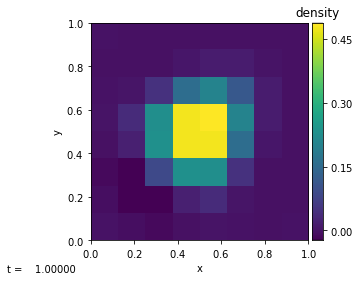

<Figure size 432x288 with 0 Axes>

In [9]:
pyro_sim.sim.dovis()

## Other solvers

![compressible](quad.png) 


## Other solvers

![incompressible](shear.png)

## Multigrid

![mg](mg_hg.gif)

![docs](docs.png)